In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/bioimaging/train/'
test_dir = "data/bioimaging/test/"

extracted_features_dir = "extracted_features/"
model_name = "bioimaging_ResNet50"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/bioimaging/train/ 0
data/bioimaging/train/carcinoma 5696
data/bioimaging/train/non-carcinoma 5696
******************************
data/bioimaging/test/ 0
data/bioimaging/test/carcinoma 36
data/bioimaging/test/non-carcinoma 35


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 8544 images belonging to 2 classes.
Found 2848 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 8544
nb_validation_samples: 2848

predict_size_train: 267
predict_size_validation: 89
nb_test_samples: 71
predict_size_test: 3

 num_classes: 2


In [9]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [10]:
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet


input_tensor = Input(shape = input_shape)  
model = ResNet50(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
# c1 = model.layers[9].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[55].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[143].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[483].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c3, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
# bottleneck_final_model.summary()

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 8544 samples, validate on 2848 samples
Epoch 1/1000
 - 2s - loss: 0.7512 - acc: 0.5092 - val_loss: 0.6786 - val_acc: 0.6043
Epoch 2/1000
 - 1s - loss: 0.6912 - acc: 0.5330 - val_loss: 0.6718 - val_acc: 0.6419
Epoch 3/1000
 - 1s - loss: 0.6756 - acc: 0.5648 - val_loss: 0.6684 - val_acc: 0.5758
Epoch 4/1000
 - 1s - loss: 0.6687 - acc: 0.5835 - val_loss: 0.6606 - val_acc: 0.6401
Epoch 5/1000
 - 1s - loss: 0.6639 - acc: 0.5961 - val_loss: 0.6658 - val_acc: 0.5597
Epoch 6/1000
 - 1s - loss: 0.6569 - acc: 0.6104 - val_loss: 0.6558 - val_acc: 0.5797
Epoch 7/1000
 - 1s - loss: 0.6507 - acc: 0.6277 - val_loss: 0.6440 - val_acc: 0.6654
Epoch 8/1000
 - 1s - loss: 0.6442 - acc: 0.6272 - val_loss: 0.6370 - val_acc: 0.6784
Epoch 9/1000
 - 1s - loss: 0.6405 - acc: 0.6357 - val_loss: 0.6321 - val_acc: 0.6699
Epoch 10/1000
 - 1s - loss: 0.6340 - acc: 0.6431 - val_loss: 0.6293 - val_acc: 0.6496
Epoch 11/1000
 - 1s - loss: 0.6301 - acc: 0.6465 - val_loss: 0.6329 - val_acc: 0.6520
Epoch 12/1000
 

Epoch 96/1000
 - 1s - loss: 0.4813 - acc: 0.7582 - val_loss: 0.5071 - val_acc: 0.7405
Epoch 97/1000
 - 1s - loss: 0.4840 - acc: 0.7592 - val_loss: 0.4907 - val_acc: 0.7563
Epoch 98/1000
 - 1s - loss: 0.4810 - acc: 0.7575 - val_loss: 0.4889 - val_acc: 0.7539
Epoch 99/1000
 - 1s - loss: 0.4797 - acc: 0.7585 - val_loss: 0.4902 - val_acc: 0.7546
Epoch 100/1000
 - 1s - loss: 0.4806 - acc: 0.7590 - val_loss: 0.4870 - val_acc: 0.7626
Epoch 101/1000
 - 1s - loss: 0.4781 - acc: 0.7619 - val_loss: 0.5171 - val_acc: 0.7402
Epoch 102/1000
 - 1s - loss: 0.4789 - acc: 0.7569 - val_loss: 0.4951 - val_acc: 0.7514
Epoch 103/1000
 - 1s - loss: 0.4766 - acc: 0.7580 - val_loss: 0.4868 - val_acc: 0.7591
Epoch 104/1000
 - 1s - loss: 0.4769 - acc: 0.7590 - val_loss: 0.4954 - val_acc: 0.7444
Epoch 105/1000
 - 1s - loss: 0.4760 - acc: 0.7653 - val_loss: 0.4975 - val_acc: 0.7384
Epoch 106/1000
 - 1s - loss: 0.4759 - acc: 0.7599 - val_loss: 0.4837 - val_acc: 0.7588
Epoch 107/1000
 - 1s - loss: 0.4753 - acc: 0.76

Epoch 191/1000
 - 1s - loss: 0.4206 - acc: 0.7980 - val_loss: 0.4844 - val_acc: 0.7577
Epoch 192/1000
 - 1s - loss: 0.4207 - acc: 0.8028 - val_loss: 0.4764 - val_acc: 0.7644
Epoch 193/1000
 - 1s - loss: 0.4210 - acc: 0.8028 - val_loss: 0.4534 - val_acc: 0.7774
Epoch 194/1000
 - 1s - loss: 0.4216 - acc: 0.8001 - val_loss: 0.4706 - val_acc: 0.7644
Epoch 195/1000
 - 1s - loss: 0.4161 - acc: 0.8059 - val_loss: 0.4822 - val_acc: 0.7669
Epoch 196/1000
 - 1s - loss: 0.4174 - acc: 0.8008 - val_loss: 0.4730 - val_acc: 0.7683
Epoch 197/1000
 - 1s - loss: 0.4174 - acc: 0.8056 - val_loss: 0.4518 - val_acc: 0.7788
Epoch 198/1000
 - 1s - loss: 0.4211 - acc: 0.7975 - val_loss: 0.4963 - val_acc: 0.7581
Epoch 199/1000
 - 1s - loss: 0.4152 - acc: 0.8028 - val_loss: 0.4648 - val_acc: 0.7679
Epoch 200/1000
 - 1s - loss: 0.4130 - acc: 0.8065 - val_loss: 0.4598 - val_acc: 0.7683
Epoch 201/1000
 - 1s - loss: 0.4151 - acc: 0.8057 - val_loss: 0.4549 - val_acc: 0.7711
Epoch 202/1000
 - 1s - loss: 0.4179 - acc: 

 - 1s - loss: 0.3760 - acc: 0.8294 - val_loss: 0.4405 - val_acc: 0.7816
Epoch 286/1000
 - 1s - loss: 0.3793 - acc: 0.8270 - val_loss: 0.4768 - val_acc: 0.7665
Epoch 287/1000
 - 1s - loss: 0.3731 - acc: 0.8349 - val_loss: 0.4376 - val_acc: 0.7848
Epoch 288/1000
 - 1s - loss: 0.3785 - acc: 0.8261 - val_loss: 0.4276 - val_acc: 0.7939
Epoch 289/1000
 - 1s - loss: 0.3767 - acc: 0.8276 - val_loss: 0.4323 - val_acc: 0.7939
Epoch 290/1000
 - 1s - loss: 0.3766 - acc: 0.8250 - val_loss: 0.4255 - val_acc: 0.7967
Epoch 291/1000
 - 1s - loss: 0.3772 - acc: 0.8291 - val_loss: 0.4312 - val_acc: 0.7890
Epoch 292/1000
 - 1s - loss: 0.3727 - acc: 0.8331 - val_loss: 0.4375 - val_acc: 0.7872
Epoch 293/1000
 - 1s - loss: 0.3752 - acc: 0.8301 - val_loss: 0.4762 - val_acc: 0.7760
Epoch 294/1000
 - 1s - loss: 0.3782 - acc: 0.8264 - val_loss: 0.4556 - val_acc: 0.7802
Epoch 295/1000
 - 1s - loss: 0.3751 - acc: 0.8295 - val_loss: 0.4551 - val_acc: 0.7749
Epoch 296/1000
 - 1s - loss: 0.3740 - acc: 0.8277 - val_lo

Epoch 380/1000
 - 1s - loss: 0.3376 - acc: 0.8531 - val_loss: 0.4293 - val_acc: 0.7971
Epoch 381/1000
 - 1s - loss: 0.3340 - acc: 0.8500 - val_loss: 0.4127 - val_acc: 0.8062
Epoch 382/1000
 - 1s - loss: 0.3372 - acc: 0.8538 - val_loss: 0.4173 - val_acc: 0.8086
Epoch 383/1000
 - 1s - loss: 0.3362 - acc: 0.8524 - val_loss: 0.4484 - val_acc: 0.7890
Epoch 384/1000
 - 1s - loss: 0.3340 - acc: 0.8528 - val_loss: 0.4323 - val_acc: 0.7974
Epoch 385/1000
 - 1s - loss: 0.3392 - acc: 0.8496 - val_loss: 0.4042 - val_acc: 0.8125
Epoch 386/1000
 - 1s - loss: 0.3352 - acc: 0.8523 - val_loss: 0.4047 - val_acc: 0.8093
Epoch 387/1000
 - 1s - loss: 0.3353 - acc: 0.8470 - val_loss: 0.4098 - val_acc: 0.8093
Epoch 388/1000
 - 1s - loss: 0.3299 - acc: 0.8574 - val_loss: 0.4107 - val_acc: 0.8129
Epoch 389/1000
 - 1s - loss: 0.3363 - acc: 0.8532 - val_loss: 0.4091 - val_acc: 0.8076
Epoch 390/1000
 - 1s - loss: 0.3358 - acc: 0.8508 - val_loss: 0.4217 - val_acc: 0.8027
Epoch 391/1000
 - 1s - loss: 0.3300 - acc: 

 - 1s - loss: 0.3041 - acc: 0.8680 - val_loss: 0.4270 - val_acc: 0.8129
Epoch 475/1000
 - 1s - loss: 0.3035 - acc: 0.8695 - val_loss: 0.4027 - val_acc: 0.8157
Epoch 476/1000
 - 1s - loss: 0.2998 - acc: 0.8716 - val_loss: 0.3962 - val_acc: 0.8209
Epoch 477/1000
 - 1s - loss: 0.3047 - acc: 0.8700 - val_loss: 0.4182 - val_acc: 0.8069
Epoch 478/1000
 - 1s - loss: 0.3043 - acc: 0.8690 - val_loss: 0.3949 - val_acc: 0.8202
Epoch 479/1000
 - 1s - loss: 0.3061 - acc: 0.8676 - val_loss: 0.4534 - val_acc: 0.8048
Epoch 480/1000
 - 1s - loss: 0.2996 - acc: 0.8704 - val_loss: 0.4062 - val_acc: 0.8188
Epoch 481/1000
 - 1s - loss: 0.3019 - acc: 0.8738 - val_loss: 0.4123 - val_acc: 0.8153
Epoch 482/1000
 - 1s - loss: 0.3021 - acc: 0.8717 - val_loss: 0.4053 - val_acc: 0.8136
Epoch 483/1000
 - 1s - loss: 0.2990 - acc: 0.8707 - val_loss: 0.3954 - val_acc: 0.8167
Epoch 484/1000
 - 1s - loss: 0.3013 - acc: 0.8683 - val_loss: 0.3944 - val_acc: 0.8192
Epoch 485/1000
 - 1s - loss: 0.3016 - acc: 0.8713 - val_lo

Epoch 569/1000
 - 1s - loss: 0.2788 - acc: 0.8810 - val_loss: 0.3912 - val_acc: 0.8318
Epoch 570/1000
 - 1s - loss: 0.2734 - acc: 0.8841 - val_loss: 0.4272 - val_acc: 0.8178
Epoch 571/1000
 - 1s - loss: 0.2728 - acc: 0.8849 - val_loss: 0.3742 - val_acc: 0.8360
Epoch 572/1000
 - 1s - loss: 0.2718 - acc: 0.8878 - val_loss: 0.3919 - val_acc: 0.8297
Epoch 573/1000
 - 1s - loss: 0.2739 - acc: 0.8821 - val_loss: 0.3794 - val_acc: 0.8343
Epoch 574/1000
 - 1s - loss: 0.2731 - acc: 0.8849 - val_loss: 0.3950 - val_acc: 0.8269
Epoch 575/1000
 - 1s - loss: 0.2727 - acc: 0.8867 - val_loss: 0.4606 - val_acc: 0.7988
Epoch 576/1000
 - 1s - loss: 0.2758 - acc: 0.8824 - val_loss: 0.3949 - val_acc: 0.8343
Epoch 577/1000
 - 1s - loss: 0.2747 - acc: 0.8823 - val_loss: 0.3836 - val_acc: 0.8294
Epoch 578/1000
 - 1s - loss: 0.2717 - acc: 0.8881 - val_loss: 0.4361 - val_acc: 0.8079
Epoch 579/1000
 - 1s - loss: 0.2694 - acc: 0.8894 - val_loss: 0.4077 - val_acc: 0.8255
Epoch 580/1000
 - 1s - loss: 0.2763 - acc: 

 - 1s - loss: 0.2498 - acc: 0.8950 - val_loss: 0.3952 - val_acc: 0.8325
Epoch 664/1000
 - 1s - loss: 0.2559 - acc: 0.8900 - val_loss: 0.3800 - val_acc: 0.8399
Epoch 665/1000
 - 1s - loss: 0.2518 - acc: 0.8929 - val_loss: 0.3848 - val_acc: 0.8385
Epoch 666/1000
 - 1s - loss: 0.2508 - acc: 0.8952 - val_loss: 0.3834 - val_acc: 0.8353
Epoch 667/1000
 - 1s - loss: 0.2469 - acc: 0.8976 - val_loss: 0.3841 - val_acc: 0.8395
Epoch 668/1000
 - 1s - loss: 0.2483 - acc: 0.8998 - val_loss: 0.4649 - val_acc: 0.8065
Epoch 669/1000
 - 1s - loss: 0.2518 - acc: 0.8970 - val_loss: 0.3839 - val_acc: 0.8388
Epoch 670/1000
 - 1s - loss: 0.2491 - acc: 0.8948 - val_loss: 0.3785 - val_acc: 0.8346
Epoch 671/1000
 - 1s - loss: 0.2454 - acc: 0.8969 - val_loss: 0.4406 - val_acc: 0.8150
Epoch 672/1000
 - 1s - loss: 0.2460 - acc: 0.8954 - val_loss: 0.3852 - val_acc: 0.8339
Epoch 673/1000
 - 1s - loss: 0.2491 - acc: 0.8957 - val_loss: 0.3917 - val_acc: 0.8294
Epoch 674/1000
 - 1s - loss: 0.2502 - acc: 0.8983 - val_lo

Epoch 758/1000
 - 1s - loss: 0.2327 - acc: 0.9052 - val_loss: 0.3744 - val_acc: 0.8441
Epoch 759/1000
 - 1s - loss: 0.2314 - acc: 0.9019 - val_loss: 0.4240 - val_acc: 0.8213
Epoch 760/1000
 - 1s - loss: 0.2316 - acc: 0.9034 - val_loss: 0.3872 - val_acc: 0.8445
Epoch 761/1000
 - 1s - loss: 0.2322 - acc: 0.9043 - val_loss: 0.3723 - val_acc: 0.8543
Epoch 762/1000
 - 1s - loss: 0.2293 - acc: 0.9079 - val_loss: 0.3822 - val_acc: 0.8416
Epoch 763/1000
 - 1s - loss: 0.2312 - acc: 0.9064 - val_loss: 0.3666 - val_acc: 0.8473
Epoch 764/1000
 - 1s - loss: 0.2273 - acc: 0.9064 - val_loss: 0.4051 - val_acc: 0.8294
Epoch 765/1000
 - 1s - loss: 0.2312 - acc: 0.9026 - val_loss: 0.3749 - val_acc: 0.8515
Epoch 766/1000
 - 1s - loss: 0.2285 - acc: 0.9074 - val_loss: 0.3784 - val_acc: 0.8490
Epoch 767/1000
 - 1s - loss: 0.2287 - acc: 0.9034 - val_loss: 0.4067 - val_acc: 0.8406
Epoch 768/1000
 - 1s - loss: 0.2297 - acc: 0.9037 - val_loss: 0.3739 - val_acc: 0.8473
Epoch 769/1000
 - 1s - loss: 0.2293 - acc: 

 - 1s - loss: 0.2103 - acc: 0.9146 - val_loss: 0.3625 - val_acc: 0.8553
Epoch 853/1000
 - 1s - loss: 0.2138 - acc: 0.9102 - val_loss: 0.3763 - val_acc: 0.8427
Epoch 854/1000
 - 1s - loss: 0.2125 - acc: 0.9150 - val_loss: 0.3512 - val_acc: 0.8546
Epoch 855/1000
 - 1s - loss: 0.2100 - acc: 0.9135 - val_loss: 0.3852 - val_acc: 0.8385
Epoch 856/1000
 - 1s - loss: 0.2125 - acc: 0.9092 - val_loss: 0.3678 - val_acc: 0.8508
Epoch 857/1000
 - 1s - loss: 0.2076 - acc: 0.9126 - val_loss: 0.3802 - val_acc: 0.8497
Epoch 858/1000
 - 1s - loss: 0.2131 - acc: 0.9107 - val_loss: 0.3696 - val_acc: 0.8476
Epoch 859/1000
 - 1s - loss: 0.2133 - acc: 0.9127 - val_loss: 0.3636 - val_acc: 0.8529
Epoch 860/1000
 - 1s - loss: 0.2104 - acc: 0.9156 - val_loss: 0.3660 - val_acc: 0.8529
Epoch 861/1000
 - 1s - loss: 0.2188 - acc: 0.9108 - val_loss: 0.3567 - val_acc: 0.8515
Epoch 862/1000
 - 1s - loss: 0.2140 - acc: 0.9118 - val_loss: 0.3739 - val_acc: 0.8448
Epoch 863/1000
 - 1s - loss: 0.2151 - acc: 0.9133 - val_lo

Epoch 947/1000
 - 1s - loss: 0.1973 - acc: 0.9198 - val_loss: 0.3721 - val_acc: 0.8483
Epoch 948/1000
 - 1s - loss: 0.1974 - acc: 0.9198 - val_loss: 0.3647 - val_acc: 0.8574
Epoch 949/1000
 - 1s - loss: 0.1997 - acc: 0.9188 - val_loss: 0.3587 - val_acc: 0.8610
Epoch 950/1000
 - 1s - loss: 0.1999 - acc: 0.9178 - val_loss: 0.3761 - val_acc: 0.8462
Epoch 951/1000
 - 1s - loss: 0.1977 - acc: 0.9203 - val_loss: 0.3860 - val_acc: 0.8490
Epoch 952/1000
 - 1s - loss: 0.1956 - acc: 0.9182 - val_loss: 0.4224 - val_acc: 0.8294
Epoch 953/1000
 - 1s - loss: 0.2041 - acc: 0.9150 - val_loss: 0.3501 - val_acc: 0.8599
Epoch 954/1000
 - 1s - loss: 0.1973 - acc: 0.9205 - val_loss: 0.4028 - val_acc: 0.8388
Epoch 955/1000
 - 1s - loss: 0.2019 - acc: 0.9178 - val_loss: 0.3633 - val_acc: 0.8606
Epoch 956/1000
 - 1s - loss: 0.1968 - acc: 0.9219 - val_loss: 0.3592 - val_acc: 0.8571
Epoch 957/1000
 - 1s - loss: 0.1985 - acc: 0.9181 - val_loss: 0.4170 - val_acc: 0.8413
Epoch 958/1000
 - 1s - loss: 0.1909 - acc: 

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.6338028169014085


Confusion Matrix
[[28  8]
 [18 17]]


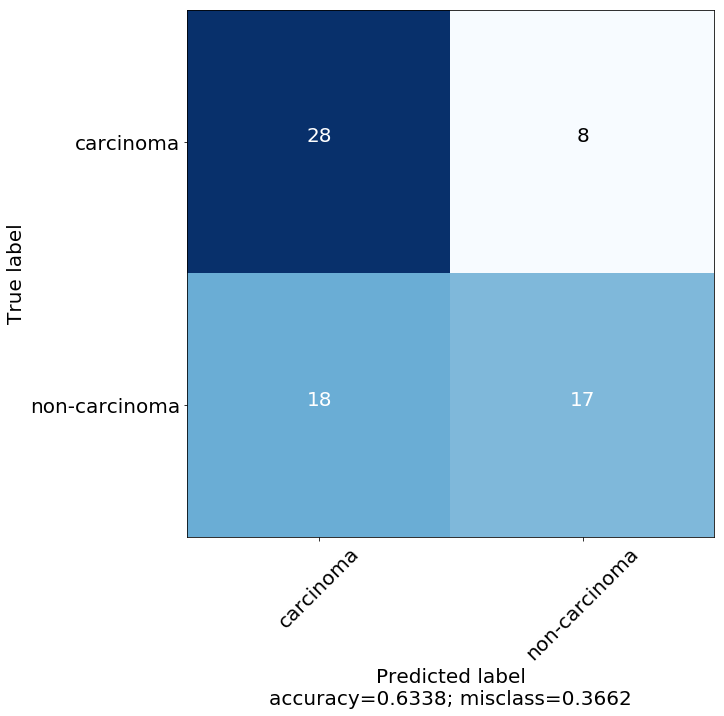

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[28  8]
 [18 17]]
               precision    recall  f1-score   support

    carcinoma       0.61      0.78      0.68        36
non-carcinoma       0.68      0.49      0.57        35

  avg / total       0.64      0.63      0.63        71



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  60.86956521739131
Specificity :  68.0


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.6443478260869566


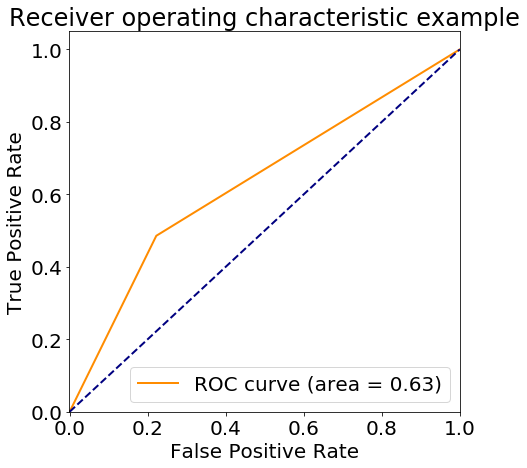

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

71/71 [==============================] - 0s 56us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

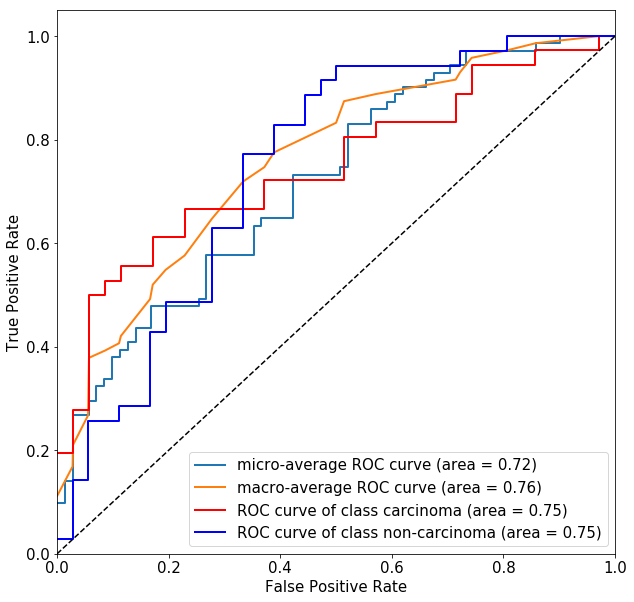

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.6338028169014085
Precision: 0.68
Recall: 0.4857142857142857
tp: 17
fp: 8
tn: 28
fn: 18


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.5666666666666667


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.5666666666666667


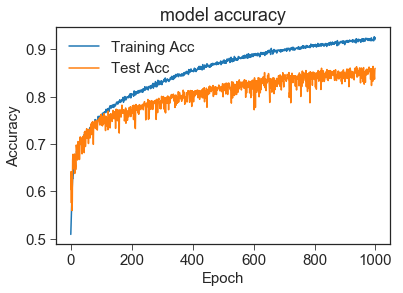

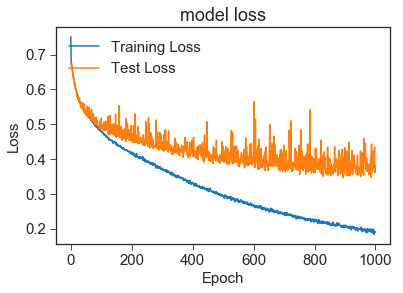

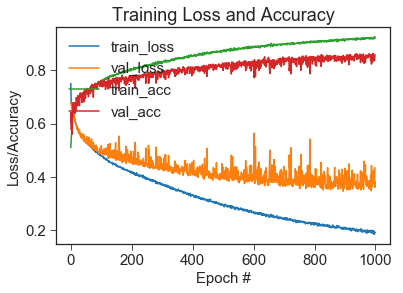

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")